In [50]:
#from tensorflow.keras.layers import Conv2D,Flatten,Dense,Maxpooling2D ,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D,Flatten,Dense ,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras .models import Sequential
from tensorflow. keras.models import Model
import matplotlib.pyplot as plt
import numpy as nр
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [51]:
img_height, img_width = (224,224)
batch_size = 32
train_data_dir = r"C:\Users\HP\Desktop\3CH\train"
valid_data_dir = r"C:\Users\HP\Desktop\3CH\valid"
test_data_dir = r"C:\Users\HP\Desktop\3CH\test"


In [52]:
train_datagen =ImageDataGenerator(preprocessing_function=preprocess_input,
     shear_range=0.2,
     zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4)


In [45]:
train_generator = train_datagen.flow_from_directory(
     train_data_dir,
    target_size=(img_height, img_width),
     batch_size = batch_size,
     class_mode = 'categorical',
     subset = 'training') #a set as training data
valid_generator = train_datagen.flow_from_directory(
     valid_data_dir, # same directory as training data
    target_size=(img_height, img_width),
     batch_size=batch_size,
    class_mode='categorical',
    subset='validation')# a set as validation data


Found 736 images belonging to 2 classes.
Found 122 images belonging to 2 classes.


In [46]:
test_generator = train_datagen.flow_from_directory(
    test_data_dir, # same directory as training data
    target_size=(img_height, img_width),
     batch_size=1,
     class_mode= 'categorical',
     subset ="validation") # set as vol idation data


Found 162 images belonging to 2 classes.


In [47]:
x,y = test_generator.next()
x.shape

(1, 224, 224, 3)

In [48]:
train_generator.num_classes

2

In [53]:
base_model = ResNet50(include_top=False, weights='imagenet')
x=base_model.output
x=GlobalAveragePooling2D()(x)
x= Dense(1024, activation= 'relu')(x)
predictions = Dense(train_generator.num_classes, activation= 'softmax')(x)
model=Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer. trainable = False
model.compile(loss = 'categorical_crossentropy',
            optimizer = 'adam',
            metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),'accuracy'])
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='camvid_model_150_epochs_checkpoint.h5', monitor='accuracy', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_accuracy', patience=10, verbose=1)
callbacks = [tb, mc, es]
result=model.fit(train_generator,epochs = 2, callbacks=callbacks)


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/2
23/23 [==============================] - 89s 4s/step - loss: 0.5503 - precision: 0.7446 - recall: 0.7446 - accuracy: 0.7446

Epoch 00001: accuracy improved from -inf to 0.74457, saving model to camvid_model_150_epochs_checkpoint.h5
Epoch 2/2
23/23 [==============================] - 83s 4s/step - loss: 0.3772 - precision: 0.7948 - recall: 0.7948 - accuracy: 0.7948

Epoch 00002: accuracy improved from 0.74457 to 0.79484, saving model to camvid_model_150_epochs_checkpoint.h5


In [54]:
result.history

{'loss': [0.5503097772598267, 0.3772002160549164],
 'precision': [0.7445651888847351, 0.7948369383811951],
 'recall': [0.7445651888847351, 0.7948369383811951],
 'accuracy': [0.7445651888847351, 0.7948369383811951]}

In [55]:
model.save('prediction.h5')

In [61]:
batch_img,batch_mask = next(test_generator)
pred_all= model.predict(batch_img)
np.shape(pred_all)


(1, 2)

In [77]:
a = ['Background', 'weed', 'crop']
b = [(0, 0, 0), (255, 0, 0), (0, 255, 0)]
label_codes, label_names =b,a
label_codes, label_names = list(label_codes), list(label_names)
label_codes[:], label_names[:]

([(0, 0, 0), (255, 0, 0), (0, 255, 0)], ['Background', 'weed', 'crop'])

In [79]:
label_codes, label_names

([(0, 0, 0), (255, 0, 0), (0, 255, 0)], ['Background', 'weed', 'crop'])

In [80]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

In [81]:
name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [82]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)





Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\HP\AppData\Local\Temp\ipykernel_9540\2947468294.py:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=None)
C:\Users\HP\AppData\Local\Temp\ipykernel_9540\2947468294.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax2.grid(b=None)
C:\Users\HP\AppData\Local\Temp\ipykernel_9540\2947468294.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax3.grid(b=None)


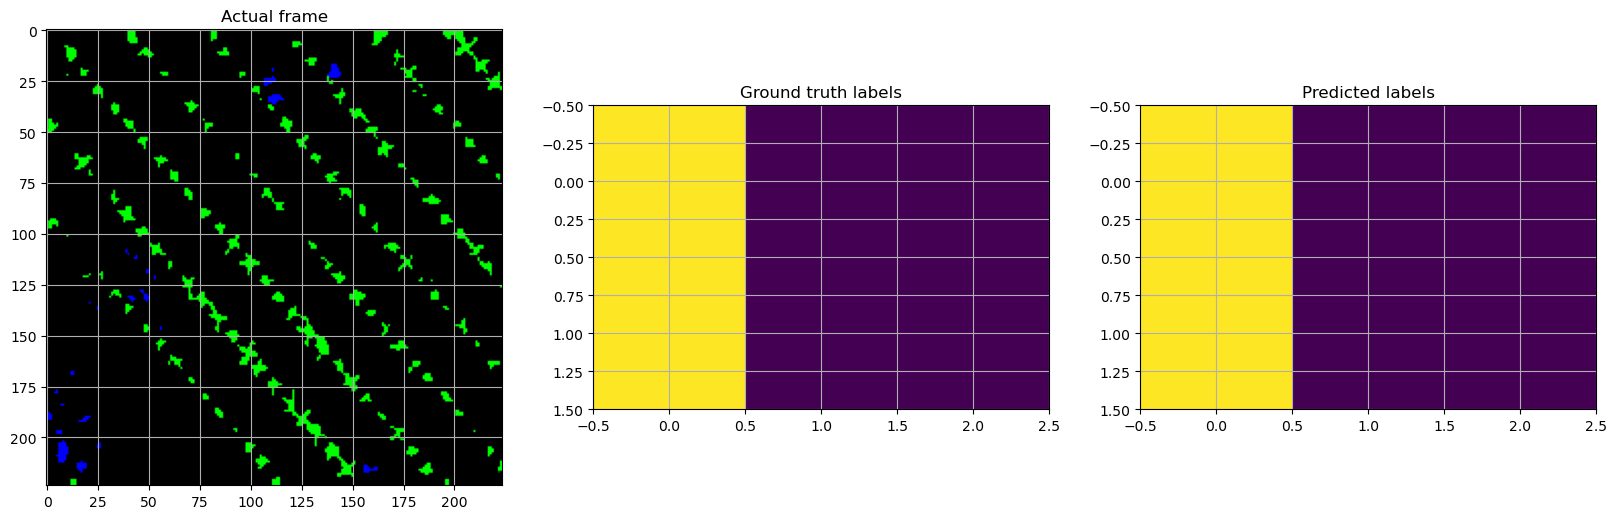

In [88]:
for i in range(0,np.shape(pred_all)[0]):
    
    fig = plt.figure(figsize=(20,8))
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(batch_img[i])
    ax1.title.set_text('Actual frame')
    ax1.grid(b=None)
    
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground truth labels')
    ax2.imshow(onehot_to_rgb(batch_mask[i],id2code))
    ax2.grid(b=None)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted labels')
    ax3.imshow(onehot_to_rgb(pred_all[i],id2code))
    ax3.grid(b=None)
    
    plt.show()

In [57]:
test_loss,test_precsion, test_recall, test_acc = model.evaluate(test_generator, verbose=2)
print("\nTest accuracy:", test_acc)

162/162 - 25s - loss: 0.4774 - precision: 0.7407 - recall: 0.7407 - accuracy: 0.7407

Test accuracy: 0.7407407164573669


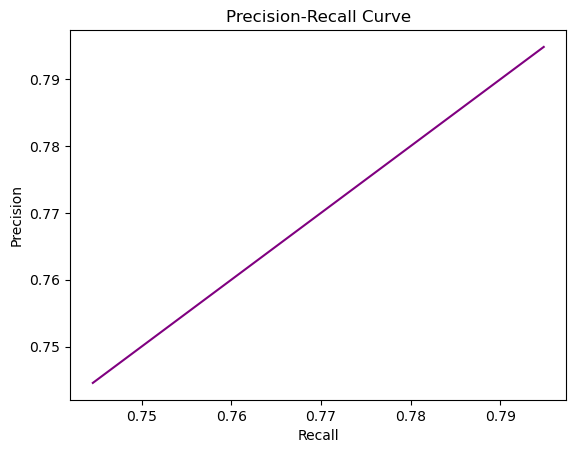

In [60]:
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(result.history['recall'], result.history['precision'], color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

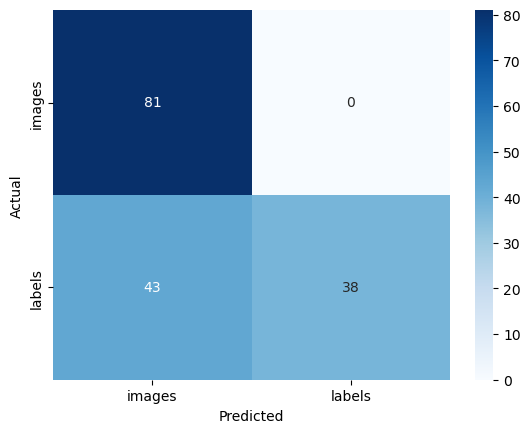

test accuracy : 73.4567901234568


In [41]:
import pandas as pd
import seaborn as sn
import tensorflow as tf
import numpy as np
model =tf.keras.models.load_model("prediction.h5")
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    x_test,Y_test = test_generator.next()
    y_prob.append(model.predict(x_test))
    y_act.append(Y_test)
predicted_class =[list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]
out_df= pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, cmap= "Blues", annot=True,fmt="d")
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))